## Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
The results from this notebook are used in [arXiv:2102.04975 [quant-ph]](https://arxiv.org/abs/2102.04975).

#### Software versions (used to make the plots in the paper)
  * Python: 3.8.7
    * qiskit: 0.23.5
      * qiskit-terra: 0.16.4
      * qiskit-aer: 0.7.4
      * qiskit-ignis: 0.5.2
      * qiskit-ibmq-provider: 0.11.1
      * qiskit-aqua: 0.8.2
    * numpy: 1.20.1
    * matplotlib: 3.3.4

**Optional:**  
Set `usejournalfonts = True` to use the same fonts used in the journal template. This has additional LaTeX and Ghostscript requirements. Set `usejournalfonts = False` to use the regular matplotlib fonts.

In [1]:
import qiskit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

## Code block to print the Python and package versions
print_versions = False
if print_versions:
    import platform
    print("Software versions")
    print(f"  * Python: {platform.python_version()}")
    print(f"    * qiskit: {qiskit.__qiskit_version__['qiskit']}")
    for key, version in qiskit.__qiskit_version__.items():
        if key != 'qiskit':
            print(f"      * {key}: {version}")
    print(f"    * numpy: {np.__version__}")
    print(f"    * matplotlib: {mpl.__version__}")

In [2]:
usejournalfonts = True

if usejournalfonts: # Slow and has additional software requirements
    default_fontsize = 22
    mpl.rc('text', usetex=usejournalfonts)
    mpl.rc('text.latex', preamble=r'\usepackage[tt=false, type1=true]{libertine} \usepackage[libertine]{newtxmath}')
    
    import subprocess
    import shutil
    def compress_pdf(fname):
        tmp_fname = fname.rsplit('.', 1)[0] + "_ghostscript.pdf"
        subprocess.run(['gswin64', '-sDEVICE=pdfwrite', '-dPDFSETTINGS=/printer', '-dEmbedAllFonts=true',
                        '-dNOPAUSE', '-dQUIET', '-dBATCH', '-sOutputFile='+tmp_fname, fname])
        shutil.move(tmp_fname, fname)
else: #Faster
    default_fontsize = 18

plt.rcParams.update({'font.size': default_fontsize})

# Wrapper for circuit.draw #######################
def draw_circuit(circuit):
    mpl.rc('text', usetex=False)
    _ = circuit.draw('mpl')
    mpl.rc('text', usetex=usejournalfonts)
    return _
##################################################

# Wrapper for plt.savefig ########################
def save_figure(pltobj, fname):
    _ = pltobj.savefig(fname, bbox_inches='tight')
    if usejournalfonts:
        compress_pdf(fname)
    return _
##################################################

In [3]:
qasm_backend = qiskit.Aer.get_backend('qasm_simulator')

In [4]:
NUM_QUBITS = 8
MAX_PHASE = np.pi/4

In [5]:
first_register = qiskit.QuantumRegister(1, name='ancilla')
second_register = qiskit.QuantumRegister(NUM_QUBITS, name='q')
output_register = qiskit.ClassicalRegister(NUM_QUBITS, name='output')

control_register = qiskit.QuantumRegister(1, name='control')
control_ancilla = qiskit.QuantumRegister(1, name='controlancilla')

## Circuit $A_0$ to prepare the initial state

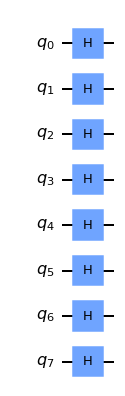

In [6]:
A0 = qiskit.QuantumCircuit(second_register, name=r'$A_0$')
A0.h(second_register)

draw_circuit(A0)

In [7]:
A0 = A0.to_gate()

A0inv = A0.inverse()
A0inv.name = r'$A_0^\dagger$'

## Selective phase flip/Diffuser $S_{\Psi_0}$

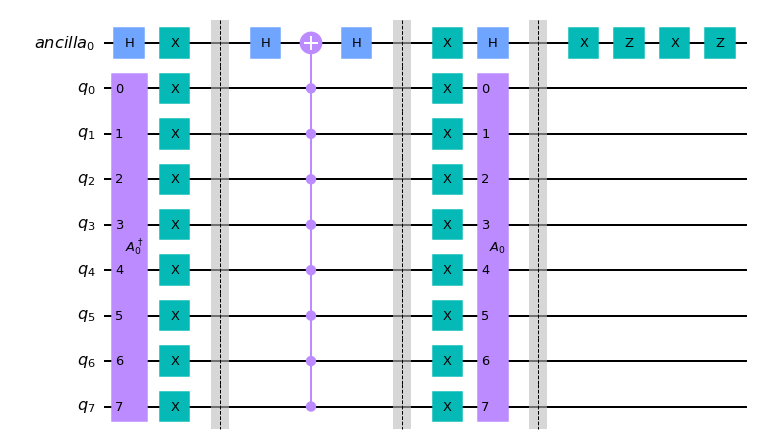

In [8]:
diffuser = qiskit.QuantumCircuit(first_register, second_register, name=r'$S_{\psi_0}$')

diffuser.h(first_register)
diffuser.append(A0inv, second_register)

diffuser.x(first_register)
diffuser.x(second_register)

diffuser.barrier()
diffuser.h(first_register)
diffuser.mct(second_register, first_register)
diffuser.h(first_register)
diffuser.barrier()

diffuser.x(first_register)
diffuser.x(second_register)

diffuser.h(first_register)
diffuser.append(A0, second_register)

diffuser.barrier()
# Correcting the global phase of pi ####
# This is NOT REQUIRED for amplitude amplification
diffuser.x(first_register)
diffuser.z(first_register)
diffuser.x(first_register)
diffuser.z(first_register)
########################################

draw_circuit(diffuser)

In [9]:
diffuser.data = [_ for _ in diffuser.data if not isinstance(_[0], qiskit.circuit.barrier.Barrier)]
diffuser = diffuser.to_gate()

## Oracle $U_\varphi$

$\displaystyle\varphi(x) = \frac{x}{255}\frac{\pi}{4}$

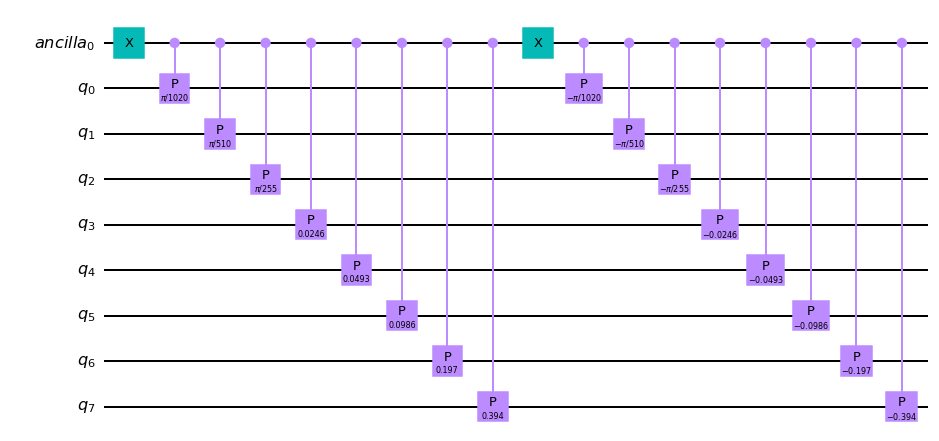

In [10]:
oracle = qiskit.QuantumCircuit(first_register, second_register, name=r'$U_\varphi$')

oracle.x(first_register)
for i in range(NUM_QUBITS):
    oracle.cp(2**i*MAX_PHASE/(2**NUM_QUBITS-1), first_register, second_register[i])

oracle.x(first_register)
for i in range(NUM_QUBITS):
    oracle.cp(-2**i*MAX_PHASE/(2**NUM_QUBITS-1), first_register, second_register[i])

draw_circuit(oracle)

In [11]:
oracle = oracle.to_gate()

## Non-Boolean Amplitude Amplification Circuit 

In [12]:
def AmplitudeAmplificationCircuit(K):
    circuit = qiskit.QuantumCircuit(first_register, second_register, output_register)
    
    circuit.h(first_register)
    circuit.append(A0, second_register)
    
    circuit.barrier()
    
    for k in range(K):
        circuit.x(first_register)
        circuit.append(oracle, [*first_register, *second_register])
        circuit.append(diffuser, [*first_register, *second_register])
        circuit.barrier()
    
    circuit.measure(second_register, output_register)
    
    return circuit

#### Circuit for K = 2

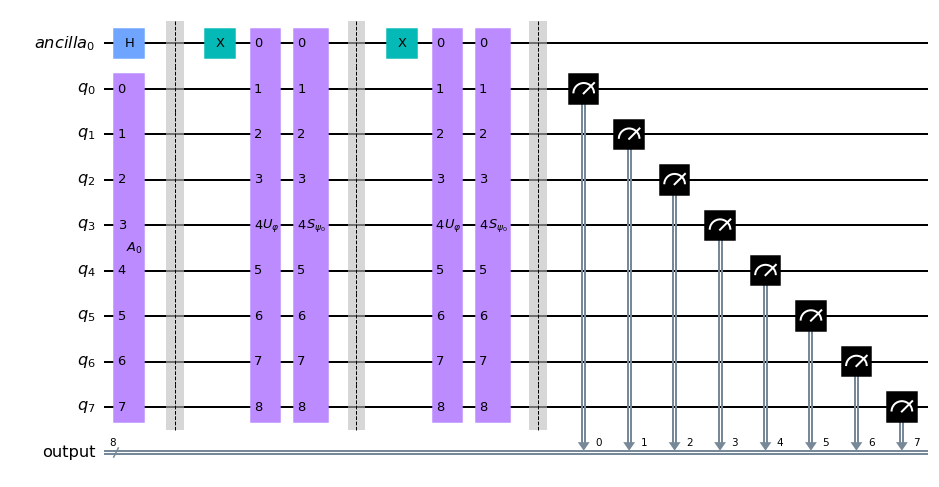

In [13]:
K = 2
circuit = AmplitudeAmplificationCircuit(K)
draw_circuit(circuit)

#### Simulations

In [14]:
SHOTS = 1_000_000
SIMULATION_SEED = 0

counts_dicts = [None]
counts_arrays = [None]
for K in range(1, 4):
    circuit = AmplitudeAmplificationCircuit(K)
    
    this_counts_dict = qiskit.execute(circuit, backend=qasm_backend, shots=SHOTS, seed_simulator=SIMULATION_SEED).result().get_counts()
    this_counts_array = np.zeros(2**NUM_QUBITS, dtype=int)
    for s in this_counts_dict:
        this_counts_array[int(s, 2)] = this_counts_dict[s]
    
    counts_dicts.append(this_counts_dict)
    counts_arrays.append(this_counts_array)

#### Calculations

In [15]:
costheta = 0
for i in range(2**NUM_QUBITS):
    costheta += np.cos(i*MAX_PHASE/(2**NUM_QUBITS-1))
costheta /= 2**NUM_QUBITS
theta = np.arccos(costheta)
Ktilde = int( np.floor(np.pi/(2*theta)) )

lambda_K = lambda K: (costheta - np.cos((2*K+1)*theta))/(np.sin(theta)**2)

print(f"cos(theta) = {costheta}")
print(f"{theta = }")
print(f"{Ktilde = }\n")

for K in range(15):
    print(f"lambda_{K} = {lambda_K(K)}")

cos(theta) = 0.9001329395324632
theta = 0.4507217315006597
Ktilde = 3

lambda_0 = 0.0
lambda_1 = 3.6005317581298524
lambda_2 = 8.068637694400019
lambda_3 = 10.01283432608506
lambda_4 = 7.957393266799735
lambda_5 = 3.462482180809644
lambda_6 = -0.06006919420884212
lambda_7 = 0.06350627614657871
lambda_8 = 3.7394095252113666
lambda_9 = 8.177472788139085
lambda_10 = 10.009016256036354
lambda_11 = 7.843820111408751
lambda_12 = 3.325360821937169
lambda_13 = -0.1166577812283078
lambda_14 = 0.13040361852040636


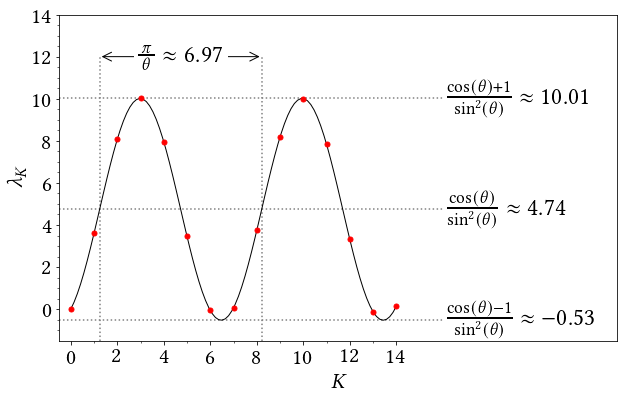

In [16]:
K_continuous = np.linspace(0, 14, 100)
K_discrete = np.arange(0, 15, 1)

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

ax.plot(K_continuous, lambda_K(K_continuous), color='black', linewidth=1)
ax.plot(K_discrete, lambda_K(K_discrete), color='red', marker='o', markersize=5, linewidth=0)

ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-1.5, 14)

ax.hlines(y=[(costheta-1)/(1-costheta**2), costheta/(1-costheta**2), (costheta+1)/(1-costheta**2)],
          xmin=-0.5, xmax=16, linestyles='dotted', colors='gray')
ax.text(16.2, costheta/(1-costheta**2), r"$\frac{\cos(\theta)}{\sin^2(\theta)} \approx $" + fr" ${costheta/(1-costheta**2):.3}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta+1)/(1-costheta**2), r"$\frac{\cos(\theta)+1}{\sin^2(\theta)} \approx $" + fr" ${(costheta+1)/(1-costheta**2):.4}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta-1)/(1-costheta**2), r"$\frac{\cos(\theta)-1}{\sin^2(\theta)} \approx $" + fr" ${(costheta-1)/(1-costheta**2):.2}$",
        ha='left', va='center', fontsize=default_fontsize+2)

ax.vlines(x=[np.pi/(4*theta) - 0.5, 5*np.pi/(4*theta) - 0.5],
          ymin=-1.5, ymax=(costheta+1)/(1-costheta**2) + 2, colors='gray', linestyles='dotted')
ax.annotate("", xy=(np.pi/(4*theta) - 0.5, 12), xytext=(5*np.pi/(4*theta) - 0.5, 12), textcoords=ax.transData, arrowprops={'arrowstyle':'<->'})
ax.text(3*np.pi/(4*theta) - 0.5, 12, r"$\frac{\,\pi\,}{\theta} \approx $" + fr" ${np.pi/theta:.3}$",
        ha="center", va="center", bbox={'color':'white'}, fontsize=default_fontsize+2)

ax.set_xticks(range(0, 15, 2))
ax.set_xticks(range(1, 15, 2), minor=True)
ax.set_yticks(range(0, 15, 2))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$\lambda_K$')

save_figure(plt, "lambda.pdf")

#### Frequency histogram

In [17]:
x_array = np.array(range(2**NUM_QUBITS), dtype='float')

fig, ax = plt.subplots(figsize=(9.5,7))
fig.patch.set_facecolor('white')

colors = [None, 'green', 'red', 'blue']

for K in range(1, 4):
    # Extending the first and last bins by 0.5 ########
    _x = np.insert(x_array, [0, len(x_array)], [-0.5, 2**NUM_QUBITS-0.5])
    _y = np.insert(counts_arrays[K], [0, len(x_array)], [counts_arrays[K][0], counts_arrays[K][-1]])
    ###################################################
    
    ax.step(_x, _y/SHOTS, where='mid', 
            linewidth=1, color=colors[K], label=fr'Observed for $K$ = {K}')

for K in range(1, 4):
    ax.plot(x_array, (1 - lambda_K(K)*(np.cos(x_array*MAX_PHASE/255) - costheta))/256, 
            linestyle=(0, (5,5)), linewidth=1, color=colors[K], label=fr'Prediction for $K$ = {K}')

ax.text(20, counts_arrays[1][20]/SHOTS+.0002, "$K=1$", color=colors[1], ha='center', rotation=3)
ax.text(40, counts_arrays[2][40]/SHOTS+.00005, "$K=2$", color=colors[2], ha='center', rotation=11)
ax.text(75, counts_arrays[3][70]/SHOTS-.0008, "$K=3$", color=colors[3], ha='center', rotation=22)

ax.set_xlabel(r"Measurement outcome $x$")
ax.set_ylabel(r"Frequency")

ax.set_ylim(0, .012)
ax.set_xlim(-1.5, 256.5)

stable_x = theta*(2**NUM_QUBITS-1)/MAX_PHASE

ax.vlines(x=stable_x, ymin=0, ymax=2/2**NUM_QUBITS, colors='purple', linestyles='dotted')
ax.hlines(y=1/2**NUM_QUBITS, xmin=2*stable_x-256.5, xmax=256.5, colors='purple', linestyles='dotted')

ax.text(224, 1/2**NUM_QUBITS-1e-4, r"$p_0(x) = 1/2^8$", ha='center', va='top', color='purple')
ax.text(stable_x+1.5, 0.0002, r"$x = \varphi^{-1}(\theta)$", ha='left', va='bottom', color='purple', rotation=90)

ax.xaxis.set_major_locator(MultipleLocator(32))
ax.xaxis.set_minor_locator(MultipleLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend(ncol=2, fontsize=default_fontsize-3.7)
save_figure(plt, "amplification_histograms.pdf")

## Controlled $Q_\mathrm{iter}$

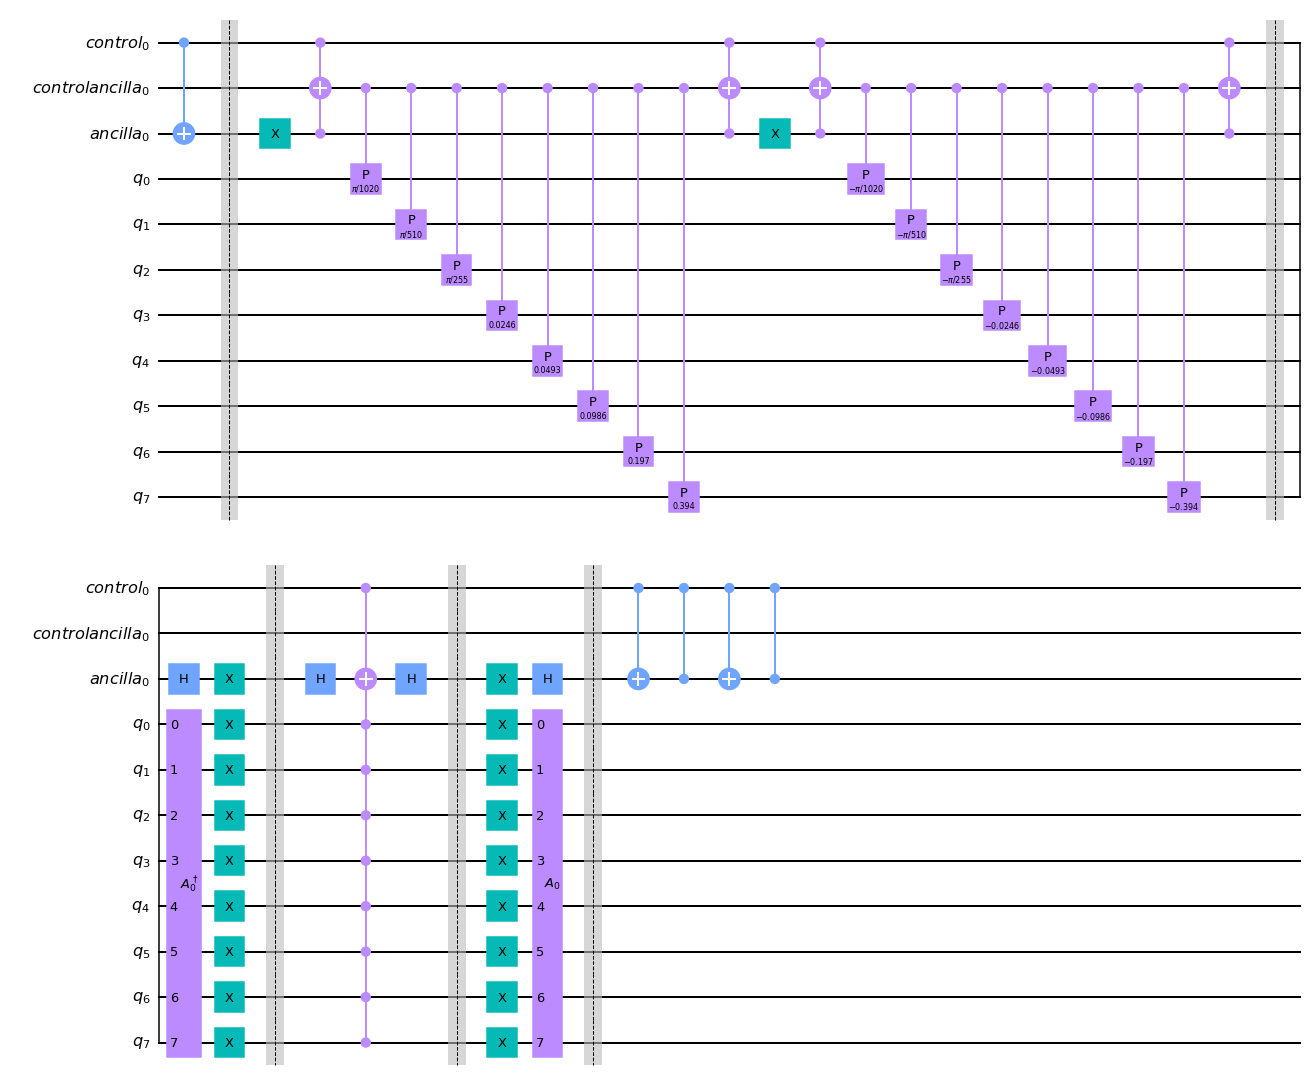

In [18]:
CQiter = qiskit.QuantumCircuit(control_register, control_ancilla, first_register, second_register, name=r'$CQ_\mathrm{iter}$')

CQiter.cx(control_register, first_register)
CQiter.barrier()

# Controlled oracle ##############################
CQiter.x(first_register)
CQiter.mct([*control_register, *first_register], control_ancilla)
for i in range(NUM_QUBITS):
    CQiter.cp(2**i*MAX_PHASE/(2**NUM_QUBITS-1), control_ancilla, second_register[i])
CQiter.mct([*control_register, *first_register], control_ancilla)

CQiter.x(first_register)
CQiter.mct([*control_register, *first_register], control_ancilla)
for i in range(NUM_QUBITS):
    CQiter.cp(-2**i*MAX_PHASE/(2**NUM_QUBITS-1), control_ancilla, second_register[i])
CQiter.mct([*control_register, *first_register], control_ancilla)

CQiter.barrier()
##################################################

# Controlled diffuser ############################
CQiter.h(first_register)
CQiter.append(A0inv, second_register)

CQiter.x(first_register)
CQiter.x(second_register)

CQiter.barrier()
CQiter.h(first_register)
CQiter.mct([*control_register, *second_register], first_register)
CQiter.h(first_register)
CQiter.barrier()

CQiter.x(first_register)
CQiter.x(second_register)

CQiter.h(first_register)
CQiter.append(A0, second_register)

CQiter.barrier()
# Correcting the global phase of pi ####
# This is REQUIRED for mean estimation
CQiter.cx(control_register, first_register)
CQiter.cz(control_register, first_register)
CQiter.cx(control_register, first_register)
CQiter.cz(control_register, first_register)
########################################

draw_circuit(CQiter)

In [19]:
CQiter.data = [_ for _ in CQiter.data if not isinstance(_[0], qiskit.circuit.barrier.Barrier)]
CQiter = CQiter.to_gate()

## Quantum Mean Estimation Circuit

In [20]:
def MeanEstimationCircuit(NUM_PHASE_QUBITS):
    phase_register = qiskit.QuantumRegister(NUM_PHASE_QUBITS, name='counting')
    phase_output_register = qiskit.ClassicalRegister(NUM_PHASE_QUBITS, name='output')
    
    circuit = qiskit.QuantumCircuit(first_register, second_register, phase_register, control_ancilla, phase_output_register)
    
    circuit.h(first_register)
    circuit.append(A0, second_register)
    circuit.h(phase_register)
    circuit.barrier()
    
    for i in range(NUM_PHASE_QUBITS):
        for _ in range(2**i):
            circuit.append(CQiter, [phase_register[i], *control_ancilla, *first_register, *second_register])
    circuit.barrier()
    
    # Inverse Quantum Fourier Transform #########
    for i in range(NUM_PHASE_QUBITS//2):
        circuit.swap(phase_register[i], phase_register[NUM_PHASE_QUBITS-i-1])
    for i in range(NUM_PHASE_QUBITS):
        for j in range(i):
            circuit.cp(-np.pi/2**(i-j), phase_register[j], phase_register[i])
        circuit.h(phase_register[i])
    #############################################
    
    circuit.measure(phase_register, phase_output_register)
    
    return circuit

#### Simulations

In [21]:
SHOTS = 1_000_000
SIMULATION_SEED = 0

NUM_PHASE_QUBITS_LIST = [4, 8]
counts_dicts_list = []

for NUM_PHASE_QUBITS in NUM_PHASE_QUBITS_LIST:
    circuit = MeanEstimationCircuit(NUM_PHASE_QUBITS)
    this_counts_dict = qiskit.execute(circuit, backend=qasm_backend, shots=SHOTS, seed_simulator=SIMULATION_SEED).result().get_counts()
    counts_dicts_list.append(this_counts_dict)

#### Frequency histograms

In [22]:
phase_values_list = []
phase_counts_list = []

cosphase_binedges_list = []
cosphase_counts_list = []

for i in range(len(NUM_PHASE_QUBITS_LIST)):
    NUM_PHASE_QUBITS = NUM_PHASE_QUBITS_LIST[i]
    this_counts_dict = counts_dicts_list[i]
    
    ## phase histograms ################
    phase_values = np.linspace(0, 2*np.pi, 2**NUM_PHASE_QUBITS+1, endpoint=True)
    
    phase_counts = np.zeros(2**NUM_PHASE_QUBITS+1, int)
    for s in this_counts_dict:
        phase_counts[int(s, 2)] = this_counts_dict[s]
    phase_counts[-1] = phase_counts[0]
    
    phase_values_list.append(phase_values)
    phase_counts_list.append(phase_counts)
    
    ## cos(phase) histograms ###########
    phase_midpoints = (phase_values[1:] + phase_values[:-1])/2
    
    cosphase_binedges = [1]
    for j in range(2**(NUM_PHASE_QUBITS-1)):
        cosphase_binedges.append(np.cos(phase_midpoints[j]))
    cosphase_binedges.append(-1)
    cosphase_binedges = np.array(cosphase_binedges)
    
    cosphase_counts = [phase_counts[0]]
    for j in range(1, 2**(NUM_PHASE_QUBITS-1)):
        cosphase_counts.append(phase_counts[j]+phase_counts[2**NUM_PHASE_QUBITS-j])
    cosphase_counts.append(phase_counts[2**(NUM_PHASE_QUBITS-1)])
    cosphase_counts = np.array(cosphase_counts)
    
    cosphase_binedges_list.append(cosphase_binedges)
    cosphase_counts_list.append(cosphase_counts)

In [23]:
fig, ax = plt.subplots(figsize=(9.5,7))
fig.patch.set_facecolor('white')

colors = ['green', 'red']
linestyles = [(0, (4, 4)), 'solid']

for i in range(len(NUM_PHASE_QUBITS_LIST)):
    binwidth = (2*np.pi)/2**NUM_PHASE_QUBITS_LIST[i]
    ax.step(phase_values_list[i], phase_counts_list[i] / (SHOTS*binwidth), where='mid',
            color=colors[i], linestyle=linestyles[i], linewidth=1.5, label=f"{NUM_PHASE_QUBITS_LIST[i]} phase measurement qubits")

ax.set_xticks(np.linspace(0, 2*np.pi, 8+1, endpoint=True))
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False)+np.pi/8, minor=True)
ax.set_xticklabels([0, r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$', r'$2\pi$'])

ax.set_xlabel(r"Phase estimate $\hat{\omega}$", fontsize=default_fontsize+4)
ax.set_ylabel(r"Frequency / bin-width", fontsize=default_fontsize+4)

ax.set_xlim(-np.pi/16, 33*np.pi/16)
legend = plt.legend(loc=9, fontsize=default_fontsize+3.6)

ax.plot([theta]*2, [0, 25], linestyle=(0, (1, 2)), linewidth='1.5', color='purple')
ax.plot([2*np.pi-theta]*2, [0, 25], linestyle=(0, (1, 2)), linewidth='1.5', color='purple')
ax.set_yscale('log')
ax.set_ylim(top=25)

text1 = ax.text(theta, 10**-3, r"$\hat{\omega} = \theta$",
                ha='right', va='center', rotation=90, color='purple', fontsize=default_fontsize+2)
text2 = ax.text(2*np.pi-theta+.1, 2*10**-4, r"$\hat{\omega} = 2\pi - \theta$",
                ha='left', va='bottom', rotation=90, color='purple', fontsize=default_fontsize+2)

save_figure(fig, 'phase_histogram_log.pdf')

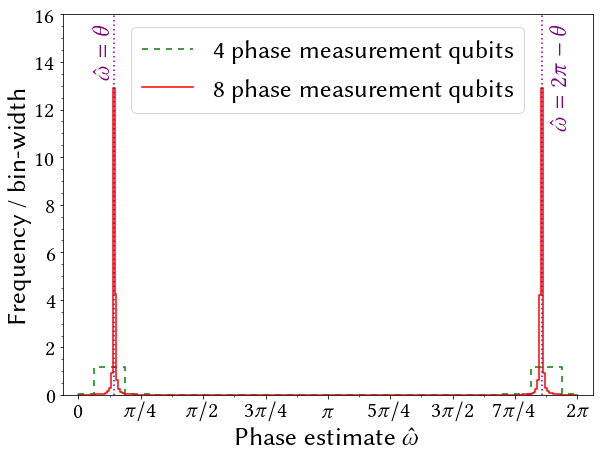

In [24]:
text1.remove()
text2.remove()

ax.text(theta, 15.5, r"$\hat{\omega} = \theta$",
        ha='right', va='top', rotation=90, color='purple', fontsize=default_fontsize+2)
ax.text(2*np.pi-theta+.1, 15.5, r"$\hat{\omega} = 2\pi - \theta$",
        ha='left', va='top', rotation=90, color='purple', fontsize=default_fontsize+2)

ax.set_yscale('linear')
ax.set_ylim(0, 16)
ax.yaxis.set_minor_locator(AutoMinorLocator())

save_figure(fig, 'phase_histogram.pdf')
fig #to show the modified figure

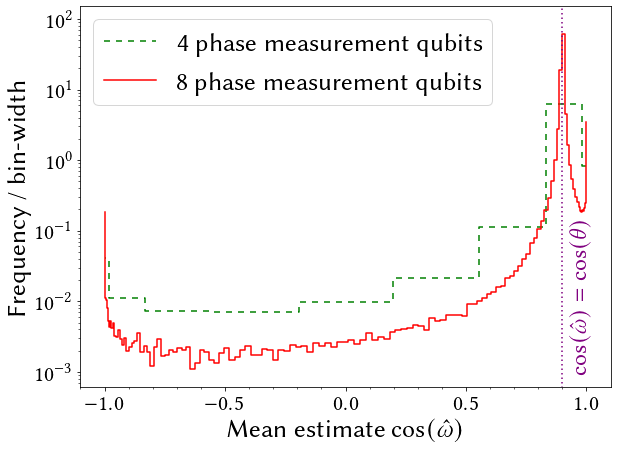

In [25]:
fig, ax = plt.subplots(figsize=(9.5,7))
fig.patch.set_facecolor('white')

colors = ['green', 'red']
linestyles = [(0, (4, 4)), 'solid']

for i in range(len(NUM_PHASE_QUBITS_LIST)):
    cosphase_binedges = cosphase_binedges_list[i]
    cosphase_counts = cosphase_counts_list[i]
    
    cosphase_binwidths = np.absolute(cosphase_binedges[1:]-cosphase_binedges[:-1])
    cosphase_binwidths = np.insert(cosphase_binwidths, 0, cosphase_binwidths[0])
    cosphase_counts = np.insert(cosphase_counts, 0, cosphase_counts[0])
    
    ax.step(cosphase_binedges, cosphase_counts/(SHOTS*cosphase_binwidths), where='pre',
            color=colors[i], linestyle=linestyles[i], linewidth=1.5, label=f"{NUM_PHASE_QUBITS_LIST[i]} phase measurement qubits")

ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel(r"Mean estimate $\cos(\hat{\omega})$", fontsize=default_fontsize+4)
ax.set_ylabel(r"Frequency / bin-width", fontsize=default_fontsize+4)

ax.set_xlim(-1.1, 1.1)
plt.legend(loc=2, fontsize=default_fontsize+4)

ax.plot([costheta]*2, [0, 150], linestyle=(0, (1, 2)), linewidth='1.5', color='purple')
ax.set_yscale('log')
ax.set_ylim(top=150)

text = ax.text(np.cos(theta)+.03, 9*10**-4, r"$\cos(\hat{\omega}) = \cos(\theta)$",
               ha='left', va='bottom', rotation=90, color='purple', fontsize=default_fontsize+2)

save_figure(fig, 'cosphase_histogram_log.pdf')

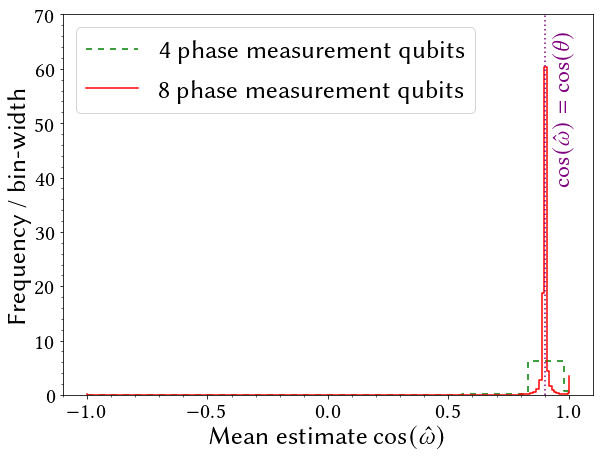

In [26]:
text.remove()

ax.text(np.cos(theta)+.03, 67, r"$\cos(\hat{\omega}) = \cos(\theta)$",
        ha='left', va='top', rotation=90, color='purple', fontsize=default_fontsize+2)

ax.set_yscale('linear')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim(0, 70)

save_figure(fig, 'cosphase_histogram.pdf')
fig #to show the modified figure